<a href="https://colab.research.google.com/github/vforjj/AI-ML-Review/blob/main/Chapter08_%EA%B3%B5%EC%A1%B0%EA%B8%B0%EA%B8%B0_%EC%A0%84%EB%A0%A5_%EC%82%AC%EC%9A%A9_%EC%83%81%ED%83%9C_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Chapter 08]**  
**┗ 공조기기 전력 사용 상태 분석**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* Data Spec Check
* 문제해결 프로세스 정의
* Data Info Check
* 🥉Session 1 - 「Data Readiness Check」
* 🥈Session 2 - 「Feature Engineering」
* 🥇Session 3 - 「Modeling」

In [ ]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/00.fast_campus/00.HyperDifference/03.Part4/Chapter08")
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks/00.fast_campus/00.HyperDifference/03.Part4/Chapter08'

In [ ]:
# 한글 폰트를 사용하기 위해 나눔고딕 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 설치 후 반드시 Runtime -> Restart runtime 실행해야 적용됨

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (6,979 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 128276 files and di

# **문제상황 및 데이터 살펴보기**
---
> **시나리오** 🏭

```
우리 공장에는 다양한 설비가 있다.
설비들에 대한 예지보전은 생산성에 매우 큰 영향을 미치기 때문에,
센서 값에 따라 설비의 건강상태를 예측하는 것이 매우 중요한 일이다.
설비에서 발생하는 센서데이터들을 살펴보고, SOH(State Of Health)에 대해 예측할 수 있는 모델을 만들어보자.
```



> **데이터 살펴보기**

* 1분 간격 설비 센서데이터
* 데이터 명세 ⬇

|Column|Description|
|:---|:---|
|DEVICE_ID|설비 번호|
|DEVICE_BD_ID|설비가 설치된 건물 번호|
|data|설비에서 발생하는 센서데이터가 담겨있는 json 형태의 데이터|

> **세부 데이터 살펴보기 (data column)**

* data: {
         "ITEM_NAME":"센서 이름",
         "ITEM_VALUE":"센서 값",
         "TIMESTAMP":"적재된 시간"
  }


> 본 실전 프로젝트에서는 건물별, 설비별 분석을 하지 않기 때문에, `DEVICE_ID`와 `DEVICE_BD_ID`는 의미가 없음. <br>
`data` column에서 값을 추출하여 데이터를 재구성

# **Data Spec Check**
---
> **Data 가공 명세서**

<img src = "https://drive.google.com/uc?id=16iCKZA8n6iHBENxqhKro31JFqowAHr8K">

# **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ Context) 공장에는 다양한 설비가 있다. 모든 설비는 제품을 생산하는 환경을 조성하기 위해 운영되고 있으며,
설비들의 상태에 따라 제품의 품질이 결정된다.
▶ As-IS) 현재는 1년에 한번씩 계획 정비를 하거나, 문제가 발생할 경우 해당 설비를 멈추고 조치를 취하고 있다.
이때는 생산이 중단되기 때문에 손실이 발생하게 된다.
▶ To-BE) 회사에서는 각 설비의 건강상태를 표현하여 지속적으로 문제가 발생하는 경우, 사전에 수리를 하고자 한다.
▶ Goal) 이러한 Needs에 맞춰 설비의 SOH(State Of Health)를 예측할 수 있는 모델을 만들어보자.
```  

> **기대효과**

```
▶ 대부분의 설비는 문제가 발생하여 동작이 멈추는 경우,
1) 수리 비용 발생 2) 정지 시간동안 수행 가능한 생산에 대한 기대비용이 함께 발생하기 때문에 미연에 이상 상태를 감지하여 유지보수하는 것을 통해
1) 생산 안정성 확보 2) 다운타임 감소의 효과를 통해 전체 비용 절감을 효과를 기대할 수 있다.
```

> **해결방안**

```
▶ 수집된 데이터를 적재에 용이한 데이터의 형태 -> 분석할 수 있는 데이터 형태로 변환하고,
  데이터의 형태(시계열 데이터, 다변량 데이터 등)에 따라 시계열 분석 혹은 Tree류 알고리즘 적용을 시도할 수 있다.
  프로젝트를 진행하면서 어떤 알고리즘이 좋을지에 대해 고민해보자.
▶ Session 1 🥉
 - Data Loading (Transformation)
 - Data Characteristic Analysis
 - Data Preprocessing
▶ Session 2 🥈
 - Data visualization
 - Check multicolinearity
▶ Session 3 🥇
 - RandomForest Classifier를 통한 모델링
```

> **성과측정**  

```
▶ 설비 SOH 예측 정확도
```

> **현업적용**  

```
▶ 수많은 센서들에서 데이터가 발생할 경우, 모두를 이용하여 분석을 하는 것보다 선택과 집중하는 방법을 이해
```

> **주요 핵심 미리 살펴보기**  

```
▶ Session 1 → Data Loading, Data Characteristic Analysis, Data Preprocessing
▶ Session 2 → Data Visualization, Check multicolinearity
▶ Session 3 → RandomForest Classifier 모델링
```

# Data Info Check

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

df = pd.read_json('data/train/SourceData_42.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509795 entries, 0 to 1509794
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   DEVICE_ID     1509795 non-null  int64 
 1   DEVICE_BD_ID  1509795 non-null  int64 
 2   data          1509795 non-null  object
dtypes: int64(2), object(1)
memory usage: 34.6+ MB


In [ ]:
# 수치형 데이터를 가진 컬럼을 살펴보자.
df.select_dtypes(include=np.number).columns.tolist()

['DEVICE_ID', 'DEVICE_BD_ID']

In [ ]:
# DataFrame의 describe 함수를 통해 수치형 컬럼의 통계량을 확인하자.
df.describe()

,DEVICE_ID,DEVICE_BD_ID
count,1509795.0,1509795.0
mean,1333.0,1.0
std,0.0,0.0
min,1333.0,1.0
25%,1333.0,1.0
50%,1333.0,1.0
75%,1333.0,1.0
max,1333.0,1.0


In [ ]:
# object(dict) 타입으로 저장된 data column에 실제 분석 대상 데이터가 저장되어있음
df['data'][0]

{'ITEM_NAME': '누적전력량',
 'ITEM_VALUE': 79569.8047,
 'TIMESTAMP': '2020-10-22 00:00:40'}

In [ ]:
# json type으로 저장된 데이터를 분석에 사용할 수 있는 데이터로 변환
for idx, val in enumerate(df['data'].values):
  if idx == 30: break
  print(val['ITEM_NAME'], val['ITEM_VALUE'], val['TIMESTAMP'])

누적전력량 79569.8047 2020-10-22 00:00:40
선간전압평균 396.25 2020-10-22 00:00:40
온도 14.375 2020-10-22 00:00:40
역률평균 0.631358 2020-10-22 00:00:40
유효전력평균 8620.5 2020-10-22 00:00:40
상전압평균 228.916672 2020-10-22 00:00:40
전압고조파평균 7.421875 2020-10-22 00:00:40
주파수 59.882084 2020-10-22 00:00:40
전류고조파평균 119.88932 2020-10-22 00:00:40
무효전력평균 10588.5 2020-10-22 00:00:40
전류평균 19.979166 2020-10-22 00:00:40
전류고조파평균 120.963539 2020-10-22 00:01:40
전압고조파평균 7.5846350000000005 2020-10-22 00:01:40
누적전력량 79715.1 2020-10-22 00:01:40
선간전압평균 395.833344 2020-10-22 00:01:40
전류평균 20.052084 2020-10-22 00:01:40
유효전력평균 8639 2020-10-22 00:01:40
온도 15 2020-10-22 00:01:40
상전압평균 229 2020-10-22 00:01:40
역률평균 0.6379589999999999 2020-10-22 00:01:40
무효전력평균 10428 2020-10-22 00:01:40
주파수 59.891457 2020-10-22 00:01:40
선간전압평균 396 2020-10-22 00:02:40
전류평균 20.291666 2020-10-22 00:02:40
역률평균 0.641102 2020-10-22 00:02:40
전압고조파평균 7.324219 2020-10-22 00:02:40
누적전력량 79860.06 2020-10-22 00:02:40
온도 15 2020-10-22 00:02:40
무효전력평균 10365 2020-10-22 0

In [ ]:
# json type으로 저장된 데이터를 분석에 사용할 수 있는 데이터로 변환
cur_date = None
for idx, val in enumerate(df['data'].values):
  if idx == 30: break
  print(val['ITEM_NAME'], val['ITEM_VALUE'], val['TIMESTAMP'])
  if cur_date is None:
    # cur_date가 비어있을 경우 TIMESTAMP로 초기화
    cur_date = val['TIMESTAMP']
  if cur_date == val['TIMESTAMP']:
    continue
  elif cur_date != val['TIMESTAMP']:
    print("Detect change value of TIMESTAMP")
    break

누적전력량 79569.8047 2020-10-22 00:00:40
선간전압평균 396.25 2020-10-22 00:00:40
온도 14.375 2020-10-22 00:00:40
역률평균 0.631358 2020-10-22 00:00:40
유효전력평균 8620.5 2020-10-22 00:00:40
상전압평균 228.916672 2020-10-22 00:00:40
전압고조파평균 7.421875 2020-10-22 00:00:40
주파수 59.882084 2020-10-22 00:00:40
전류고조파평균 119.88932 2020-10-22 00:00:40
무효전력평균 10588.5 2020-10-22 00:00:40
전류평균 19.979166 2020-10-22 00:00:40
전류고조파평균 120.963539 2020-10-22 00:01:40
Detect change value of TIMESTAMP


|TIMESTAMP|누적전력량|온도|역률평균|유효전력평균|상전압평균|전압고조파평균|주파수|전류고조파평균|무효전력평균|전류평균|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|2020-10-22 00:00:40|79569.8047|396.25|14.375|0.631358|8620.5|228.916672|7.421875|59.882084|119.88932|10588.5|19.979166|

In [ ]:
#set 자료형의 특성을 이용해서 unique한 컬럼만 꺼내보자.
column_candidate = []
for idx, val in enumerate(df['data'].values):
  column_candidate.append(val['ITEM_NAME'])
print(len(column_candidate))
set(column_candidate)

1509795


{'R상무효전력',
 'R상선간전압',
 'R상역률',
 'R상유효전력',
 'R상전류',
 'R상전류고조파',
 'R상전압',
 'R상전압고조파',
 'S상무효전력',
 'S상선간전압',
 'S상역률',
 'S상유효전력',
 'S상전류',
 'S상전류고조파',
 'S상전압',
 'S상전압고조파',
 'T상무효전력',
 'T상선간전압',
 'T상역률',
 'T상유효전력',
 'T상전류',
 'T상전류고조파',
 'T상전압',
 'T상전압고조파',
 '누적전력량',
 '무효전력평균',
 '상전압평균',
 '선간전압평균',
 '역률평균',
 '온도',
 '유효전력평균',
 '전류고조파평균',
 '전류평균',
 '전압고조파평균',
 '주파수'}

In [ ]:
df.shape

(1509795, 3)

In [ ]:
for i in df.iterrows():
  print(i['ITEM_NAME'])

In [ ]:
# 위 데이터를 분석에 사용하기 위해서는 `data` 컬럼에 있는 dict 데이터를 풀어서 사용해야 함
# ITEM_NAME: 센서명, ITEM_VALUE: 센서값, TIMESTAMP: 수집시각
df['item_name'], df['item_value'], df['timestamp'] = zip(*df['data'].apply(lambda x: [x['ITEM_NAME'], x['ITEM_VALUE'], x['TIMESTAMP']]))
# 분석에 사용할 수 있도록 시계열 데이터로 재구성한다.
target = df.pivot(index='timestamp', columns='item_name', values='item_value').reset_index()
target

item_name,timestamp,R상무효전력,R상선간전압,R상역률,R상유효전력,R상전류,R상전류고조파,R상전압,R상전압고조파,S상무효전력,S상선간전압,S상역률,S상유효전력,S상전류,S상전류고조파,S상전압,S상전압고조파,T상무효전력,T상선간전압,T상역률,T상유효전력,T상전류,T상전류고조파,T상전압,T상전압고조파,누적전력량,무효전력평균,상전압평균,선간전압평균,역률평균,온도,유효전력평균,전류고조파평균,전류평균,전압고조파평균,주파수
0,2020-10-22 00:00:40,3611.0,397.00,0.628906,2932.5,20.28125,116.894531,229.00,7.031250,3651.0,396.25,0.625000,2947.5,20.28125,121.386719,229.25,7.519531,3326.5,395.50,0.632813,2740.5,19.37500,121.386719,228.50,7.714844,7.956980e+04,10588.5,228.916672,396.250000,0.631358,14.375,8620.5,119.889320,19.979166,7.421875,59.882084
1,2020-10-22 00:01:40,3573.5,397.25,0.628906,2910.5,20.87500,121.386719,229.25,6.933594,3645.5,395.25,0.636719,3030.0,20.68750,122.070313,229.50,7.617188,3209.0,395.00,0.640625,2698.5,18.59375,120.507813,228.25,8.007813,7.971510e+04,10428.0,229.000000,395.833344,0.637959,15.000,8639.0,120.963539,20.052084,7.584635,59.891457
2,2020-10-22 00:02:40,3534.0,397.75,0.632813,2888.5,20.43750,122.753906,230.00,6.835938,3585.5,395.50,0.640625,2996.5,21.25000,122.851563,229.00,7.324219,3245.5,394.75,0.648438,2773.5,19.18750,120.996094,228.75,7.812500,7.986006e+04,10365.0,229.250000,396.000000,0.641102,15.000,8658.5,122.200523,20.291666,7.324219,59.872750
3,2020-10-22 00:03:40,3452.5,399.00,0.644531,2940.0,19.28125,118.847656,230.00,7.617188,3433.5,396.25,0.660156,3031.5,19.75000,118.457031,230.00,7.910156,3040.5,396.00,0.660156,2693.0,17.84375,116.308594,228.75,8.300781,8.000493e+04,9926.5,229.583328,397.083344,0.657593,15.625,8664.5,117.871094,18.958334,7.942708,59.900784
4,2020-10-22 00:04:40,3615.5,397.25,0.632813,2977.5,18.87500,118.554688,229.50,7.421875,-3647.0,395.50,0.632813,2991.0,18.65625,119.726563,229.00,7.910156,3322.0,395.00,0.625000,2661.0,16.46875,117.382813,228.50,7.910156,8.014973e+04,3290.5,229.000000,395.916656,0.934377,14.375,8629.5,118.554688,18.000000,7.747396,59.714870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43132,2020-11-22 23:55:40,0.0,397.50,0.000000,0.0,0.00000,0.000000,229.50,3.027344,0.0,395.50,0.000000,0.0,0.00000,0.000000,229.25,3.027344,0.0,394.75,0.000000,0.0,0.00000,0.000000,228.50,3.320313,2.317593e+06,0.0,229.083328,395.916656,0.000000,8.125,0.0,0.000000,0.000000,3.125000,59.872757
43133,2020-11-22 23:56:40,0.0,397.50,0.000000,0.0,0.00000,0.000000,229.50,3.125000,0.0,395.75,0.000000,0.0,0.00000,0.000000,229.25,3.125000,0.0,394.50,0.000000,0.0,0.00000,0.000000,228.50,3.222656,2.317593e+06,0.0,229.083328,395.916656,0.000000,7.500,0.0,0.000000,0.000000,3.157552,59.807450
43134,2020-11-22 23:57:40,0.0,397.25,0.000000,0.0,0.00000,0.000000,229.50,3.125000,0.0,395.75,0.000000,0.0,0.00000,0.000000,229.25,3.027344,0.0,395.00,0.000000,0.0,0.00000,0.000000,228.50,3.222656,2.317593e+06,0.0,229.083328,396.000000,0.000000,8.125,0.0,0.000000,0.000000,3.125000,59.854070
43135,2020-11-22 23:58:40,0.0,397.00,0.000000,0.0,0.00000,0.000000,229.25,3.125000,0.0,396.00,0.000000,0.0,0.00000,0.000000,229.25,3.125000,0.0,395.00,0.000000,0.0,0.00000,0.000000,228.50,3.222656,2.317593e+06,0.0,229.000000,396.000000,0.000000,8.125,0.0,0.000000,0.000000,3.157552,59.844740


In [ ]:
target.shape

(43137, 36)

# 🥉Session 1 - 「Data Readiness Check」

## Data Readiness Check
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Train dataset (Feature + Label) 생성

  (2) Data type 확인

  (3) Label -> Category code 변환

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
target.head(10)

item_name,timestamp,R상무효전력,R상선간전압,R상역률,R상유효전력,R상전류,R상전류고조파,R상전압,R상전압고조파,S상무효전력,S상선간전압,S상역률,S상유효전력,S상전류,S상전류고조파,S상전압,S상전압고조파,T상무효전력,T상선간전압,T상역률,T상유효전력,T상전류,T상전류고조파,T상전압,T상전압고조파,누적전력량,무효전력평균,상전압평균,선간전압평균,역률평균,온도,유효전력평균,전류고조파평균,전류평균,전압고조파평균,주파수
0,2020-10-22 00:00:40,3611.0,397.00,0.628906,2932.5,20.28125,116.894531,229.00,7.031250,3651.0,396.25,0.625000,2947.5,20.28125,121.386719,229.25,7.519531,3326.5,395.50,0.632813,2740.5,19.37500,121.386719,228.50,7.714844,79569.8047,10588.5,228.916672,396.250000,0.631358,14.375,8620.5,119.889320,19.979166,7.421875,59.882084
1,2020-10-22 00:01:40,3573.5,397.25,0.628906,2910.5,20.87500,121.386719,229.25,6.933594,3645.5,395.25,0.636719,3030.0,20.68750,122.070313,229.50,7.617188,3209.0,395.00,0.640625,2698.5,18.59375,120.507813,228.25,8.007813,79715.1000,10428.0,229.000000,395.833344,0.637959,15.000,8639.0,120.963539,20.052084,7.584635,59.891457
2,2020-10-22 00:02:40,3534.0,397.75,0.632813,2888.5,20.43750,122.753906,230.00,6.835938,3585.5,395.50,0.640625,2996.5,21.25000,122.851563,229.00,7.324219,3245.5,394.75,0.648438,2773.5,19.18750,120.996094,228.75,7.812500,79860.0600,10365.0,229.250000,396.000000,0.641102,15.000,8658.5,122.200523,20.291666,7.324219,59.872750
3,2020-10-22 00:03:40,3452.5,399.00,0.644531,2940.0,19.28125,118.847656,230.00,7.617188,3433.5,396.25,0.660156,3031.5,19.75000,118.457031,230.00,7.910156,3040.5,396.00,0.660156,2693.0,17.84375,116.308594,228.75,8.300781,80004.9300,9926.5,229.583328,397.083344,0.657593,15.625,8664.5,117.871094,18.958334,7.942708,59.900784
4,2020-10-22 00:04:40,3615.5,397.25,0.632813,2977.5,18.87500,118.554688,229.50,7.421875,-3647.0,395.50,0.632813,2991.0,18.65625,119.726563,229.00,7.910156,3322.0,395.00,0.625000,2661.0,16.46875,117.382813,228.50,7.910156,80149.7300,3290.5,229.000000,395.916656,0.934377,14.375,8629.5,118.554688,18.000000,7.747396,59.714870
5,2020-10-22 00:05:40,3557.0,397.50,0.625000,2853.0,18.09375,109.277344,229.75,7.421875,3697.0,395.50,0.632813,3048.5,18.75000,111.328125,229.25,7.421875,3326.0,394.50,0.644531,2805.5,16.18750,112.109375,228.50,8.203125,80295.1250,10580.0,229.166672,395.833344,0.635449,14.375,8707.0,110.904945,17.677084,7.682292,59.863403
6,2020-10-22 00:06:40,3411.0,396.75,0.648438,2923.5,20.56250,117.675781,229.50,7.617188,3404.0,397.00,0.656250,2987.0,20.46875,117.578125,229.25,7.812500,2984.0,396.00,0.660156,2631.0,18.84375,116.406250,229.50,8.203125,80440.0000,9799.0,229.416672,396.583344,0.657082,14.375,8541.5,117.220055,19.958334,7.877604,59.872740
7,2020-10-22 00:07:40,3668.0,397.75,0.640625,3073.0,22.62500,123.144531,230.00,7.128906,-3657.0,395.00,0.636719,3050.5,21.31250,124.121094,228.75,7.617188,3318.0,394.50,0.625000,2668.5,19.78125,124.218750,228.50,7.714844,80585.4900,3329.0,229.083328,395.750000,0.935205,14.375,8792.0,123.828125,21.239584,7.486979,59.844750
8,2020-10-22 00:08:40,3775.0,398.00,0.621094,2993.5,18.96875,123.925781,229.50,7.421875,3810.5,397.00,0.621094,3033.0,19.56250,125.292969,229.75,7.617188,3425.0,396.00,0.625000,2759.5,18.59375,124.316406,229.00,7.617188,80731.0400,11010.5,229.416672,397.000000,0.623725,13.750,8786.0,124.511719,19.041666,7.552083,59.863403
9,2020-10-22 00:09:40,3729.0,398.00,0.613281,2912.5,19.68750,122.070313,229.50,7.421875,3839.0,397.50,0.625000,3090.5,19.90625,125.097656,230.00,7.812500,3389.0,396.75,0.625000,2715.5,17.93750,124.902344,229.00,7.910156,80876.8359,10957.0,229.500000,397.416656,0.622642,15.000,8718.5,124.023438,19.177084,7.714844,59.835594


In [ ]:
target.describe()

item_name,R상무효전력,R상선간전압,R상역률,R상유효전력,R상전류,R상전류고조파,R상전압,R상전압고조파,S상무효전력,S상선간전압,S상역률,S상유효전력,S상전류,S상전류고조파,S상전압,S상전압고조파,T상무효전력,T상선간전압,T상역률,T상유효전력,T상전류,T상전류고조파,T상전압,T상전압고조파,누적전력량,무효전력평균,상전압평균,선간전압평균,역률평균,온도,유효전력평균,전류고조파평균,전류평균,전압고조파평균,주파수
count,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,4.313700e+04,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000,43137.000000
mean,1845.574912,396.273834,0.452844,1882.613899,11.628859,63.314759,229.156869,5.472361,1432.274996,395.221341,0.433347,1771.784990,11.057080,65.517958,228.478893,5.394043,1727.733920,394.438064,0.446944,1686.958183,10.616719,64.902821,228.370410,5.433444,1.154602e+06,5006.387512,228.669115,395.311507,0.467476,11.790342,5341.265213,64.578427,11.100205,5.433427,59.855604
std,1442.756192,2.526377,0.341173,1411.263171,8.783149,47.644372,1.445637,2.176280,1721.237215,2.606271,0.359571,1329.732879,8.385714,49.223454,1.471961,2.271861,1305.012499,2.623980,0.334521,1264.999370,8.043943,48.767136,1.428896,2.196166,6.451666e+05,4060.234510,1.430341,2.542686,0.354853,5.691548,4000.873277,48.537129,8.390118,2.197928,0.080154
min,-3496.500000,386.000000,-0.800781,0.000000,0.000000,0.000000,223.000000,0.000000,-3885.500000,385.000000,-0.800781,0.000000,0.000000,0.000000,223.000000,0.000000,-3214.000000,384.000000,0.000000,0.000000,0.000000,0.000000,222.750000,0.000000,9.307579e+03,-9849.500000,223.250000,385.416656,0.000000,-1.875000,0.000000,0.000000,0.000000,0.000000,57.938824
25%,0.000000,394.500000,0.000000,0.000000,0.000000,0.000000,228.250000,4.199219,0.000000,393.500000,0.000000,0.000000,0.000000,0.000000,227.500000,4.003906,0.000000,392.750000,0.000000,0.000000,0.000000,0.000000,227.500000,4.101563,6.235051e+05,0.000000,227.666672,393.583344,0.000000,7.500000,0.000000,0.000000,0.000000,4.101563,59.844740
50%,2761.500000,396.250000,0.691406,2838.500000,16.937500,94.726560,229.250000,5.175781,2567.000000,395.250000,0.691406,2654.500000,15.906250,98.730470,228.500000,4.980469,2545.750000,394.500000,0.683594,2538.500000,15.312500,97.460940,228.500000,5.078125,1.062217e+06,7859.000000,228.666672,395.333344,0.694357,11.875000,8102.250000,97.005210,16.114584,5.078125,59.863403
75%,2943.000000,398.000000,0.714844,2970.500000,18.531250,99.414060,230.250000,6.640625,2798.500000,397.000000,0.707031,2803.000000,17.656250,102.636719,229.500000,6.640625,2739.500000,396.250000,0.703125,2672.000000,17.000000,101.855469,229.250000,6.640625,1.628591e+06,8419.500000,229.666672,397.083344,0.711782,16.250000,8412.000000,101.236977,17.697916,6.640625,59.882103
max,3871.500000,405.500000,0.824219,3983.500000,27.000000,174.414063,234.250000,11.621094,3839.000000,404.500000,0.812500,3961.000000,26.062500,181.542969,233.750000,11.621094,3636.500000,403.750000,0.808594,3608.500000,24.312500,190.625000,233.000000,11.523438,2.317593e+06,11120.000000,233.666672,404.000000,0.974008,25.000000,11553.000000,182.194016,25.791666,11.490886,60.013153


In [ ]:
# Feature와 Target을 합치기 위해 Labeling 된 데이터도 읽어온다.
label_df = pd.read_json('data/train/Combined_LabelledData_42_역률평균.json')
# LABEL_NAME과 TIMESTAMP를 이용하여 `data` 컬럼을 읽어온다.
label_df['label'], label_df['timestamp'] = zip(*label_df['data'].apply(lambda x: [x['LABEL_NAME'], x['TIMESTAMP']]))
label_df.head(5)

,SVC_NAME,BASE_ITEM,DEVICE_ID,DEVICE_BD_ID,COMPANY_NAME,ESTABLISH_YEAR,LOCATION,COMPANY_TYPE,COMPANY_CAT,MAJOR_PRODUCT,CONTRACT_POWER,BILL_OPTION,KEPCO_INFO,facility_name,facility_type_name,facility_vendor,facility_year,facility_capacity,facility_volt,data,label,timestamp
0,SOH,역률평균,1333,1,CO-295,1981,경북 고령군,제조,열처리,선박엔진,7000,산업용(을)고압A 선택II,05-****-****,집진기_1,공조설비,경원엔지니어링,2013,86,380,"{'ITEM_NAME': '누적전력량', 'ITEM_VALUE': 79569.804...",주의,2020-10-22 00:00:40
1,SOH,역률평균,1333,1,CO-295,1981,경북 고령군,제조,열처리,선박엔진,7000,산업용(을)고압A 선택II,05-****-****,집진기_1,공조설비,경원엔지니어링,2013,86,380,"{'ITEM_NAME': '전류평균', 'ITEM_VALUE': 19.979166,...",주의,2020-10-22 00:00:40
2,SOH,역률평균,1333,1,CO-295,1981,경북 고령군,제조,열처리,선박엔진,7000,산업용(을)고압A 선택II,05-****-****,집진기_1,공조설비,경원엔지니어링,2013,86,380,"{'ITEM_NAME': '선간전압평균', 'ITEM_VALUE': 396.25, ...",주의,2020-10-22 00:00:40
3,SOH,역률평균,1333,1,CO-295,1981,경북 고령군,제조,열처리,선박엔진,7000,산업용(을)고압A 선택II,05-****-****,집진기_1,공조설비,경원엔지니어링,2013,86,380,"{'ITEM_NAME': '전압고조파평균', 'ITEM_VALUE': 7.42187...",주의,2020-10-22 00:00:40
4,SOH,역률평균,1333,1,CO-295,1981,경북 고령군,제조,열처리,선박엔진,7000,산업용(을)고압A 선택II,05-****-****,집진기_1,공조설비,경원엔지니어링,2013,86,380,"{'ITEM_NAME': '유효전력평균', 'ITEM_VALUE': 8620.5, ...",주의,2020-10-22 00:00:40


In [ ]:
#Feature와 Label을 합쳐서 학습 데이터로 구성
train_data = target.merge(label_df.drop_duplicates(['timestamp', 'label'])[['timestamp', 'label']], on='timestamp', how='left')
train_data.head(10)

,timestamp,R상무효전력,R상선간전압,R상역률,R상유효전력,R상전류,R상전류고조파,R상전압,R상전압고조파,S상무효전력,S상선간전압,S상역률,S상유효전력,S상전류,S상전류고조파,S상전압,S상전압고조파,T상무효전력,T상선간전압,T상역률,T상유효전력,T상전류,T상전류고조파,T상전압,T상전압고조파,누적전력량,무효전력평균,상전압평균,선간전압평균,역률평균,온도,유효전력평균,전류고조파평균,전류평균,전압고조파평균,주파수,label
0,2020-10-22 00:00:40,3611.0,397.00,0.628906,2932.5,20.28125,116.894531,229.00,7.031250,3651.0,396.25,0.625000,2947.5,20.28125,121.386719,229.25,7.519531,3326.5,395.50,0.632813,2740.5,19.37500,121.386719,228.50,7.714844,79569.8047,10588.5,228.916672,396.250000,0.631358,14.375,8620.5,119.889320,19.979166,7.421875,59.882084,주의
1,2020-10-22 00:01:40,3573.5,397.25,0.628906,2910.5,20.87500,121.386719,229.25,6.933594,3645.5,395.25,0.636719,3030.0,20.68750,122.070313,229.50,7.617188,3209.0,395.00,0.640625,2698.5,18.59375,120.507813,228.25,8.007813,79715.1000,10428.0,229.000000,395.833344,0.637959,15.000,8639.0,120.963539,20.052084,7.584635,59.891457,주의
2,2020-10-22 00:02:40,3534.0,397.75,0.632813,2888.5,20.43750,122.753906,230.00,6.835938,3585.5,395.50,0.640625,2996.5,21.25000,122.851563,229.00,7.324219,3245.5,394.75,0.648438,2773.5,19.18750,120.996094,228.75,7.812500,79860.0600,10365.0,229.250000,396.000000,0.641102,15.000,8658.5,122.200523,20.291666,7.324219,59.872750,주의
3,2020-10-22 00:03:40,3452.5,399.00,0.644531,2940.0,19.28125,118.847656,230.00,7.617188,3433.5,396.25,0.660156,3031.5,19.75000,118.457031,230.00,7.910156,3040.5,396.00,0.660156,2693.0,17.84375,116.308594,228.75,8.300781,80004.9300,9926.5,229.583328,397.083344,0.657593,15.625,8664.5,117.871094,18.958334,7.942708,59.900784,주의
4,2020-10-22 00:04:40,3615.5,397.25,0.632813,2977.5,18.87500,118.554688,229.50,7.421875,-3647.0,395.50,0.632813,2991.0,18.65625,119.726563,229.00,7.910156,3322.0,395.00,0.625000,2661.0,16.46875,117.382813,228.50,7.910156,80149.7300,3290.5,229.000000,395.916656,0.934377,14.375,8629.5,118.554688,18.000000,7.747396,59.714870,주의
5,2020-10-22 00:05:40,3557.0,397.50,0.625000,2853.0,18.09375,109.277344,229.75,7.421875,3697.0,395.50,0.632813,3048.5,18.75000,111.328125,229.25,7.421875,3326.0,394.50,0.644531,2805.5,16.18750,112.109375,228.50,8.203125,80295.1250,10580.0,229.166672,395.833344,0.635449,14.375,8707.0,110.904945,17.677084,7.682292,59.863403,주의
6,2020-10-22 00:06:40,3411.0,396.75,0.648438,2923.5,20.56250,117.675781,229.50,7.617188,3404.0,397.00,0.656250,2987.0,20.46875,117.578125,229.25,7.812500,2984.0,396.00,0.660156,2631.0,18.84375,116.406250,229.50,8.203125,80440.0000,9799.0,229.416672,396.583344,0.657082,14.375,8541.5,117.220055,19.958334,7.877604,59.872740,주의
7,2020-10-22 00:07:40,3668.0,397.75,0.640625,3073.0,22.62500,123.144531,230.00,7.128906,-3657.0,395.00,0.636719,3050.5,21.31250,124.121094,228.75,7.617188,3318.0,394.50,0.625000,2668.5,19.78125,124.218750,228.50,7.714844,80585.4900,3329.0,229.083328,395.750000,0.935205,14.375,8792.0,123.828125,21.239584,7.486979,59.844750,주의
8,2020-10-22 00:08:40,3775.0,398.00,0.621094,2993.5,18.96875,123.925781,229.50,7.421875,3810.5,397.00,0.621094,3033.0,19.56250,125.292969,229.75,7.617188,3425.0,396.00,0.625000,2759.5,18.59375,124.316406,229.00,7.617188,80731.0400,11010.5,229.416672,397.000000,0.623725,13.750,8786.0,124.511719,19.041666,7.552083,59.863403,주의
9,2020-10-22 00:09:40,3729.0,398.00,0.613281,2912.5,19.68750,122.070313,229.50,7.421875,3839.0,397.50,0.625000,3090.5,19.90625,125.097656,230.00,7.812500,3389.0,396.75,0.625000,2715.5,17.93750,124.902344,229.00,7.910156,80876.8359,10957.0,229.500000,397.416656,0.622642,15.000,8718.5,124.023438,19.177084,7.714844,59.835594,주의


In [ ]:
train_data.shape

(43137, 37)

In [ ]:
train_data.dtypes

timestamp     object
R상무효전력       float64
R상선간전압       float64
R상역률         float64
R상유효전력       float64
R상전류         float64
R상전류고조파      float64
R상전압         float64
R상전압고조파      float64
S상무효전력       float64
S상선간전압       float64
S상역률         float64
S상유효전력       float64
S상전류         float64
S상전류고조파      float64
S상전압         float64
S상전압고조파      float64
T상무효전력       float64
T상선간전압       float64
T상역률         float64
T상유효전력       float64
T상전류         float64
T상전류고조파      float64
T상전압         float64
T상전압고조파      float64
누적전력량        float64
무효전력평균       float64
상전압평균        float64
선간전압평균       float64
역률평균         float64
온도           float64
유효전력평균       float64
전류고조파평균      float64
전류평균         float64
전압고조파평균      float64
주파수          float64
label         object
dtype: object

In [ ]:
# 설비 상태는 주의, 정상, 경고 3가지로 나눠진다.
train_data['label'].unique()

array(['주의', '정상', '경고'], dtype=object)

In [ ]:
#0: 경고, 1:정상, 2: 주의
train_data['label'].astype('category')

0        주의
1        주의
2        주의
3        주의
4        주의
         ..
43132    경고
43133    경고
43134    경고
43135    경고
43136    경고
Name: label, Length: 43137, dtype: category
Categories (3, object): ['경고', '정상', '주의']

In [ ]:
train_data['label'] = train_data['label'].astype('category').cat.codes

In [ ]:
train_data

,timestamp,R상무효전력,R상선간전압,R상역률,R상유효전력,R상전류,R상전류고조파,R상전압,R상전압고조파,S상무효전력,S상선간전압,S상역률,S상유효전력,S상전류,S상전류고조파,S상전압,S상전압고조파,T상무효전력,T상선간전압,T상역률,T상유효전력,T상전류,T상전류고조파,T상전압,T상전압고조파,누적전력량,무효전력평균,상전압평균,선간전압평균,역률평균,온도,유효전력평균,전류고조파평균,전류평균,전압고조파평균,주파수,label
0,2020-10-22 00:00:40,3611.0,397.00,0.628906,2932.5,20.28125,116.894531,229.00,7.031250,3651.0,396.25,0.625000,2947.5,20.28125,121.386719,229.25,7.519531,3326.5,395.50,0.632813,2740.5,19.37500,121.386719,228.50,7.714844,7.956980e+04,10588.5,228.916672,396.250000,0.631358,14.375,8620.5,119.889320,19.979166,7.421875,59.882084,2
1,2020-10-22 00:01:40,3573.5,397.25,0.628906,2910.5,20.87500,121.386719,229.25,6.933594,3645.5,395.25,0.636719,3030.0,20.68750,122.070313,229.50,7.617188,3209.0,395.00,0.640625,2698.5,18.59375,120.507813,228.25,8.007813,7.971510e+04,10428.0,229.000000,395.833344,0.637959,15.000,8639.0,120.963539,20.052084,7.584635,59.891457,2
2,2020-10-22 00:02:40,3534.0,397.75,0.632813,2888.5,20.43750,122.753906,230.00,6.835938,3585.5,395.50,0.640625,2996.5,21.25000,122.851563,229.00,7.324219,3245.5,394.75,0.648438,2773.5,19.18750,120.996094,228.75,7.812500,7.986006e+04,10365.0,229.250000,396.000000,0.641102,15.000,8658.5,122.200523,20.291666,7.324219,59.872750,2
3,2020-10-22 00:03:40,3452.5,399.00,0.644531,2940.0,19.28125,118.847656,230.00,7.617188,3433.5,396.25,0.660156,3031.5,19.75000,118.457031,230.00,7.910156,3040.5,396.00,0.660156,2693.0,17.84375,116.308594,228.75,8.300781,8.000493e+04,9926.5,229.583328,397.083344,0.657593,15.625,8664.5,117.871094,18.958334,7.942708,59.900784,2
4,2020-10-22 00:04:40,3615.5,397.25,0.632813,2977.5,18.87500,118.554688,229.50,7.421875,-3647.0,395.50,0.632813,2991.0,18.65625,119.726563,229.00,7.910156,3322.0,395.00,0.625000,2661.0,16.46875,117.382813,228.50,7.910156,8.014973e+04,3290.5,229.000000,395.916656,0.934377,14.375,8629.5,118.554688,18.000000,7.747396,59.714870,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43132,2020-11-22 23:55:40,0.0,397.50,0.000000,0.0,0.00000,0.000000,229.50,3.027344,0.0,395.50,0.000000,0.0,0.00000,0.000000,229.25,3.027344,0.0,394.75,0.000000,0.0,0.00000,0.000000,228.50,3.320313,2.317593e+06,0.0,229.083328,395.916656,0.000000,8.125,0.0,0.000000,0.000000,3.125000,59.872757,0
43133,2020-11-22 23:56:40,0.0,397.50,0.000000,0.0,0.00000,0.000000,229.50,3.125000,0.0,395.75,0.000000,0.0,0.00000,0.000000,229.25,3.125000,0.0,394.50,0.000000,0.0,0.00000,0.000000,228.50,3.222656,2.317593e+06,0.0,229.083328,395.916656,0.000000,7.500,0.0,0.000000,0.000000,3.157552,59.807450,0
43134,2020-11-22 23:57:40,0.0,397.25,0.000000,0.0,0.00000,0.000000,229.50,3.125000,0.0,395.75,0.000000,0.0,0.00000,0.000000,229.25,3.027344,0.0,395.00,0.000000,0.0,0.00000,0.000000,228.50,3.222656,2.317593e+06,0.0,229.083328,396.000000,0.000000,8.125,0.0,0.000000,0.000000,3.125000,59.854070,0
43135,2020-11-22 23:58:40,0.0,397.00,0.000000,0.0,0.00000,0.000000,229.25,3.125000,0.0,396.00,0.000000,0.0,0.00000,0.000000,229.25,3.125000,0.0,395.00,0.000000,0.0,0.00000,0.000000,228.50,3.222656,2.317593e+06,0.0,229.000000,396.000000,0.000000,8.125,0.0,0.000000,0.000000,3.157552,59.844740,0


In [ ]:
train_data.head(10)

,timestamp,R상무효전력,R상선간전압,R상역률,R상유효전력,R상전류,R상전류고조파,R상전압,R상전압고조파,S상무효전력,S상선간전압,S상역률,S상유효전력,S상전류,S상전류고조파,S상전압,S상전압고조파,T상무효전력,T상선간전압,T상역률,T상유효전력,T상전류,T상전류고조파,T상전압,T상전압고조파,누적전력량,무효전력평균,상전압평균,선간전압평균,역률평균,온도,유효전력평균,전류고조파평균,전류평균,전압고조파평균,주파수,label
0,2020-10-22 00:00:40,3611.0,397.00,0.628906,2932.5,20.28125,116.894531,229.00,7.031250,3651.0,396.25,0.625000,2947.5,20.28125,121.386719,229.25,7.519531,3326.5,395.50,0.632813,2740.5,19.37500,121.386719,228.50,7.714844,79569.8047,10588.5,228.916672,396.250000,0.631358,14.375,8620.5,119.889320,19.979166,7.421875,59.882084,2
1,2020-10-22 00:01:40,3573.5,397.25,0.628906,2910.5,20.87500,121.386719,229.25,6.933594,3645.5,395.25,0.636719,3030.0,20.68750,122.070313,229.50,7.617188,3209.0,395.00,0.640625,2698.5,18.59375,120.507813,228.25,8.007813,79715.1000,10428.0,229.000000,395.833344,0.637959,15.000,8639.0,120.963539,20.052084,7.584635,59.891457,2
2,2020-10-22 00:02:40,3534.0,397.75,0.632813,2888.5,20.43750,122.753906,230.00,6.835938,3585.5,395.50,0.640625,2996.5,21.25000,122.851563,229.00,7.324219,3245.5,394.75,0.648438,2773.5,19.18750,120.996094,228.75,7.812500,79860.0600,10365.0,229.250000,396.000000,0.641102,15.000,8658.5,122.200523,20.291666,7.324219,59.872750,2
3,2020-10-22 00:03:40,3452.5,399.00,0.644531,2940.0,19.28125,118.847656,230.00,7.617188,3433.5,396.25,0.660156,3031.5,19.75000,118.457031,230.00,7.910156,3040.5,396.00,0.660156,2693.0,17.84375,116.308594,228.75,8.300781,80004.9300,9926.5,229.583328,397.083344,0.657593,15.625,8664.5,117.871094,18.958334,7.942708,59.900784,2
4,2020-10-22 00:04:40,3615.5,397.25,0.632813,2977.5,18.87500,118.554688,229.50,7.421875,-3647.0,395.50,0.632813,2991.0,18.65625,119.726563,229.00,7.910156,3322.0,395.00,0.625000,2661.0,16.46875,117.382813,228.50,7.910156,80149.7300,3290.5,229.000000,395.916656,0.934377,14.375,8629.5,118.554688,18.000000,7.747396,59.714870,2
5,2020-10-22 00:05:40,3557.0,397.50,0.625000,2853.0,18.09375,109.277344,229.75,7.421875,3697.0,395.50,0.632813,3048.5,18.75000,111.328125,229.25,7.421875,3326.0,394.50,0.644531,2805.5,16.18750,112.109375,228.50,8.203125,80295.1250,10580.0,229.166672,395.833344,0.635449,14.375,8707.0,110.904945,17.677084,7.682292,59.863403,2
6,2020-10-22 00:06:40,3411.0,396.75,0.648438,2923.5,20.56250,117.675781,229.50,7.617188,3404.0,397.00,0.656250,2987.0,20.46875,117.578125,229.25,7.812500,2984.0,396.00,0.660156,2631.0,18.84375,116.406250,229.50,8.203125,80440.0000,9799.0,229.416672,396.583344,0.657082,14.375,8541.5,117.220055,19.958334,7.877604,59.872740,2
7,2020-10-22 00:07:40,3668.0,397.75,0.640625,3073.0,22.62500,123.144531,230.00,7.128906,-3657.0,395.00,0.636719,3050.5,21.31250,124.121094,228.75,7.617188,3318.0,394.50,0.625000,2668.5,19.78125,124.218750,228.50,7.714844,80585.4900,3329.0,229.083328,395.750000,0.935205,14.375,8792.0,123.828125,21.239584,7.486979,59.844750,2
8,2020-10-22 00:08:40,3775.0,398.00,0.621094,2993.5,18.96875,123.925781,229.50,7.421875,3810.5,397.00,0.621094,3033.0,19.56250,125.292969,229.75,7.617188,3425.0,396.00,0.625000,2759.5,18.59375,124.316406,229.00,7.617188,80731.0400,11010.5,229.416672,397.000000,0.623725,13.750,8786.0,124.511719,19.041666,7.552083,59.863403,2
9,2020-10-22 00:09:40,3729.0,398.00,0.613281,2912.5,19.68750,122.070313,229.50,7.421875,3839.0,397.50,0.625000,3090.5,19.90625,125.097656,230.00,7.812500,3389.0,396.75,0.625000,2715.5,17.93750,124.902344,229.00,7.910156,80876.8359,10957.0,229.500000,397.416656,0.622642,15.000,8718.5,124.023438,19.177084,7.714844,59.835594,2


# 🥈Session 2 - 「Feature Engineering」

## Feature Engineering

array([[<Axes: title={'center': 'R상무효전력'}>,
        <Axes: title={'center': 'R상선간전압'}>,
        <Axes: title={'center': 'R상역률'}>,
        <Axes: title={'center': 'R상유효전력'}>,
        <Axes: title={'center': 'R상전류'}>,
        <Axes: title={'center': 'R상전류고조파'}>],
       [<Axes: title={'center': 'R상전압'}>,
        <Axes: title={'center': 'R상전압고조파'}>,
        <Axes: title={'center': 'S상무효전력'}>,
        <Axes: title={'center': 'S상선간전압'}>,
        <Axes: title={'center': 'S상역률'}>,
        <Axes: title={'center': 'S상유효전력'}>],
       [<Axes: title={'center': 'S상전류'}>,
        <Axes: title={'center': 'S상전류고조파'}>,
        <Axes: title={'center': 'S상전압'}>,
        <Axes: title={'center': 'S상전압고조파'}>,
        <Axes: title={'center': 'T상무효전력'}>,
        <Axes: title={'center': 'T상선간전압'}>],
       [<Axes: title={'center': 'T상역률'}>,
        <Axes: title={'center': 'T상유효전력'}>,
        <Axes: title={'center': 'T상전류'}>,
        <Axes: title={'center': 'T상전류고조파'}>,
        <Axes: title={'center': 'T상전압'}>

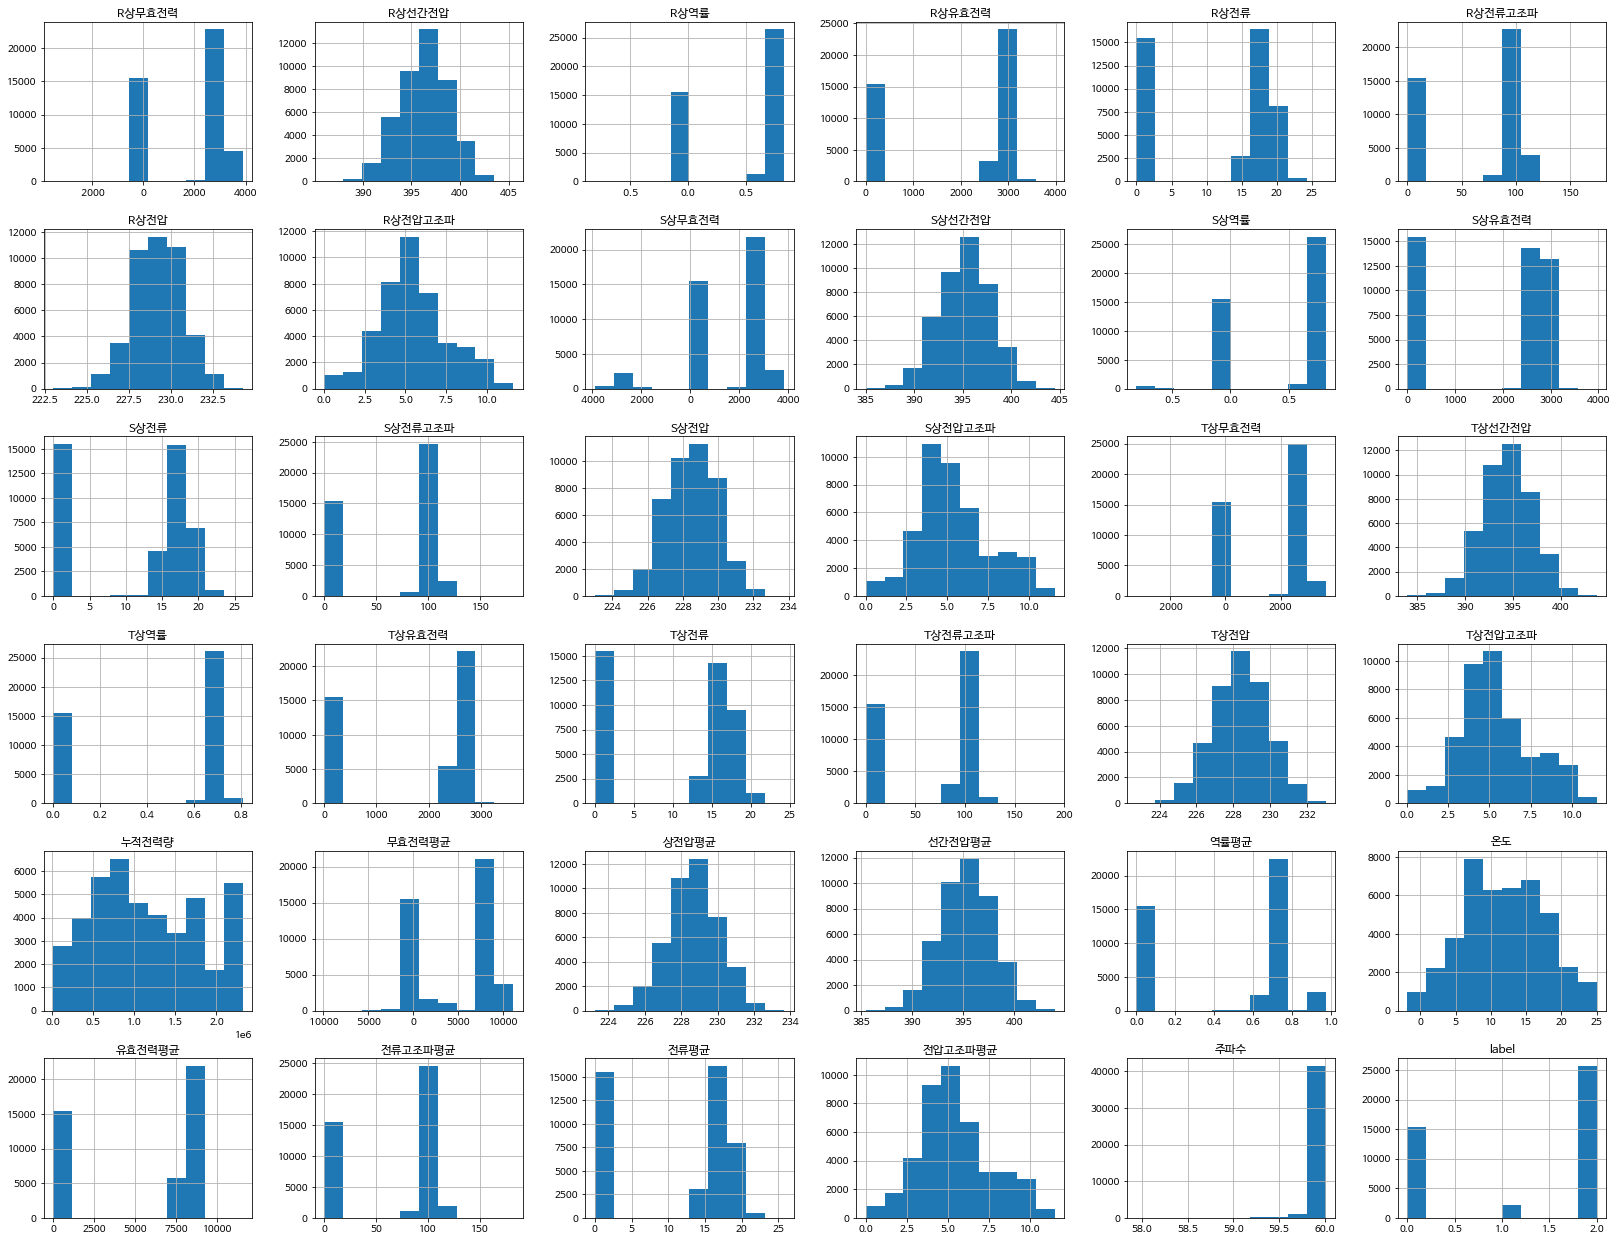

In [ ]:
plt.rc('font', family='NanumBarunGothic')
train_data.hist(figsize=(28,22))

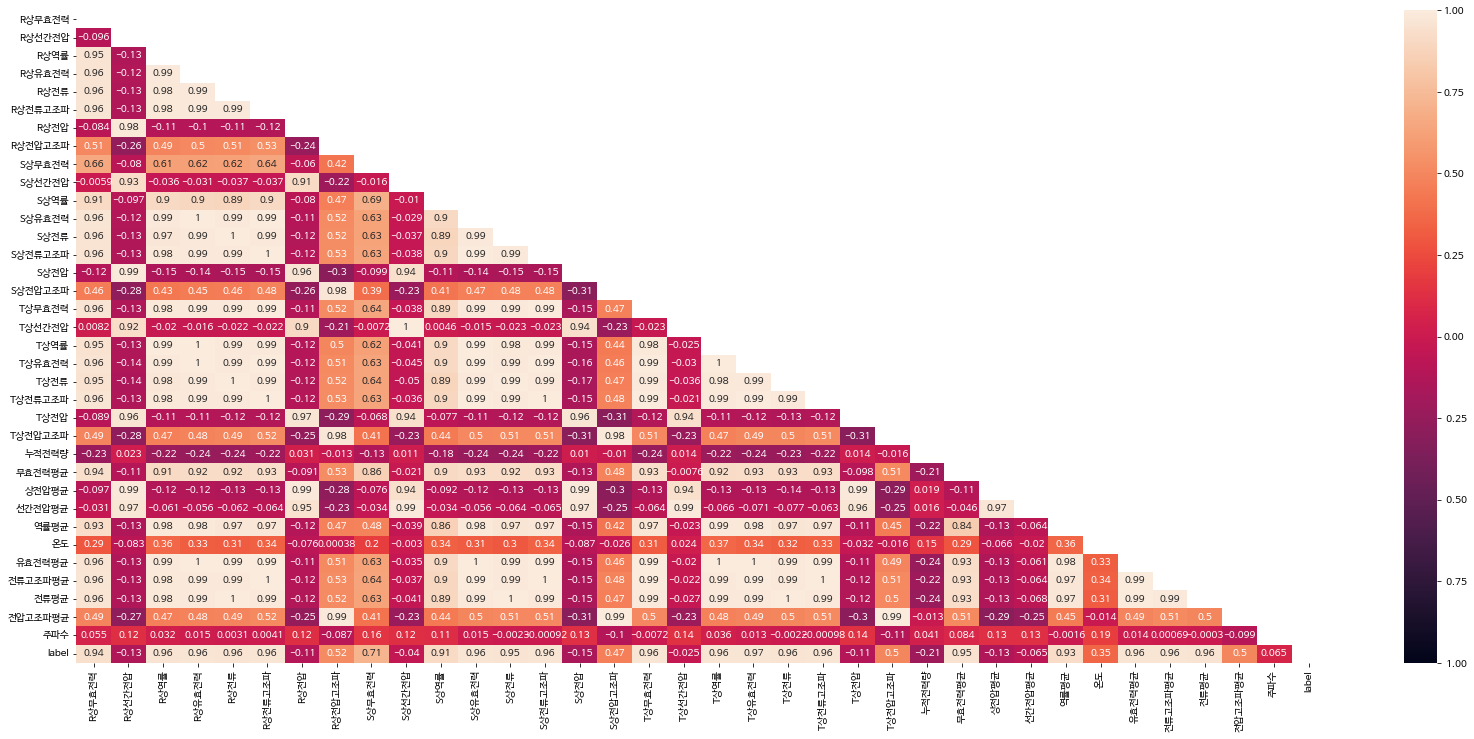

In [ ]:
plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(28,12))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(train_data.corr(), dtype=bool))

# generate heatmap
sns.heatmap(train_data.corr(), annot=True, mask=mask, vmin=-1, vmax=1)

plt.show()

In [ ]:
# 3상 모터의 경우, R, S, T 전력, 전류가 발생하는데, 이 센서들은 서로 상관관계가 높을 수 밖에 없음

다중 공선성을 측정할 수 있는 가장 간단한 방법인 VIF를 정의해보자.

In [ ]:
# compute the vif for all given features
def compute_vif(df, considered_features):
    X = df[considered_features]
    X['intercept'] = 1

    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [ ]:
# features to consider removing
considered_features = train_data.columns.tolist()
considered_features.remove('timestamp')
considered_features.remove('label')

# compute vif
compute_vif(train_data, considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
31,전류고조파평균,970969.212426
30,유효전력평균,144807.269295
13,S상전류고조파,113771.300466
21,T상전류고조파,112832.837842
5,R상전류고조파,106167.102875
3,R상유효전력,18536.626748
11,S상유효전력,16478.519766
19,T상유효전력,15590.655380
33,전압고조파평균,11920.394353
27,선간전압평균,7987.533380


책에서 배운대로 생각하면 VIF가 5가 넘는 Feature는 사용할 수 없다. 하지만, 이렇게 대부분의 Feature가 공선성이 높은 경우에는 모든 Feature를 이용해서 1차로 모델링을 진행하고 모델링의 결과를 이용하여 Feature Selection을 하는 방법도 있다.

# 🥇Session 3 - 「Modeling」

## Modeling

In [ ]:
# 거의 대부분의 센서가 전력 사용에 대한 데이터기 때문에 다중공선성이 매우 높지만,
# 다중공선성이 높은 Feature를 제거하면 모델링할 수 있는 변수가 거의 없으므로,
# Feature Importance를 통해 Feature Selection을 시도하자.

In [ ]:
y = train_data['label']
X = train_data.drop(['label', 'timestamp'], axis=1)
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle=False)

In [ ]:
rf1 = RandomForestClassifier(random_state = 0, n_estimators=50, max_features=20)
rf1.fit(train_features, train_labels)
predicted_1 = rf1.predict(test_features)
result1_train = rf1.score(train_features, train_labels)
result1_test = rf1.score(test_features, test_labels)
print(f"Train score: {result1_train}")
print(f"Test score: {result1_test}")

Train score: 0.9999710220522182
Test score: 0.951784886416319


In [ ]:
# 가장 Feature importance가 높은 20개 리스트
X.columns[rf1.feature_importances_.argsort()[::-1][:20]]

Index(['역률평균', 'R상유효전력', 'T상전류', 'S상유효전력', 'T상유효전력', 'S상전류', '전류평균', '무효전력평균',
       'T상무효전력', '유효전력평균', 'R상전류', 'T상역률', '온도', '누적전력량', 'S상무효전력', 'R상전류고조파',
       '전압고조파평균', '주파수', 'S상역률', 'S상전압고조파'],
      dtype='object')

In [ ]:
# Feature importance가 높은 20개를 선택하여 학습데이터를 재구성
X = train_data.iloc[:, rf1.feature_importances_.argsort()[::-1][:10]]
y = train_data['label']
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle=False)

In [ ]:
rf2 = RandomForestClassifier(random_state = 0, n_estimators=50, max_features=20)
rf2.fit(train_features, train_labels)
predicted_2 = rf2.predict(test_features)
result2_train = rf2.score(train_features, train_labels)
result2_test = rf2.score(test_features, test_labels)
print(f"Train score: {result2_train}")
print(f"Test score: {result2_test}")

Train score: 0.9999710220522182
Test score: 0.9515530829856282


In [ ]:
# 36개 Feature -> 10개 Feature를 사용하여도 기존의 성능을 유지

In [ ]:
test_data = pd.read_json('data/test/SourceData_42.json')
test_data

,DEVICE_ID,DEVICE_BD_ID,data
0,1333,1,"{'ITEM_NAME': '누적전력량', 'ITEM_VALUE': 2317593.2..."
1,1333,1,"{'ITEM_NAME': '주파수', 'ITEM_VALUE': 59.87275, '..."
2,1333,1,"{'ITEM_NAME': '선간전압평균', 'ITEM_VALUE': 396.1666..."
3,1333,1,"{'ITEM_NAME': '전류평균', 'ITEM_VALUE': 0, 'TIMEST..."
4,1333,1,"{'ITEM_NAME': '상전압평균', 'ITEM_VALUE': 229.08332..."
...,...,...,...
201595,1333,1,"{'ITEM_NAME': 'T상전류', 'ITEM_VALUE': 14, 'TIMES..."
201596,1333,1,"{'ITEM_NAME': 'S상무효전력', 'ITEM_VALUE': -2601.5,..."
201597,1333,1,"{'ITEM_NAME': 'R상무효전력', 'ITEM_VALUE': 2794.5, ..."
201598,1333,1,"{'ITEM_NAME': 'R상역률', 'ITEM_VALUE': 0.73046899..."


In [ ]:
test_data['item_name'], test_data['item_value'], test_data['timestamp'] = zip(*test_data['data'].apply(lambda x: [x['ITEM_NAME'], x['ITEM_VALUE'], x['TIMESTAMP']]))

In [ ]:
test_target = test_data.pivot(index='timestamp', columns='item_name', values='item_value').reset_index()
test_target

item_name,timestamp,R상무효전력,R상선간전압,R상역률,R상유효전력,R상전류,R상전류고조파,R상전압,R상전압고조파,S상무효전력,S상선간전압,S상역률,S상유효전력,S상전류,S상전류고조파,S상전압,S상전압고조파,T상무효전력,T상선간전압,T상역률,T상유효전력,T상전류,T상전류고조파,T상전압,T상전압고조파,누적전력량,무효전력평균,상전압평균,선간전압평균,역률평균,온도,유효전력평균,전류고조파평균,전류평균,전압고조파평균,주파수
0,2020-11-23 00:00:40,0.0,398.00,0.000000,0.0,0.00000,0.000000,229.75,3.222656,0.0,395.50,0.000000,0.0,0.00000,0.000000,229.25,3.027344,0.0,395.00,0.000000,0.0,0.00000,0.000000,228.25,3.222656,2317593.25,0.0,229.083328,396.166656,0.000000,8.125,0.0,0.000000,0.000000,3.157552,59.872750
1,2020-11-23 00:01:40,0.0,398.25,0.000000,0.0,0.00000,0.000000,230.00,3.222656,0.0,396.75,0.000000,0.0,0.00000,0.000000,230.00,3.125000,0.0,395.75,0.000000,0.0,0.00000,0.000000,229.00,3.222656,2317593.25,0.0,229.666672,396.916656,0.000000,8.125,0.0,0.000000,0.000000,3.190104,59.835415
2,2020-11-23 00:02:40,0.0,398.50,0.000000,0.0,0.00000,0.000000,230.25,3.125000,0.0,396.75,0.000000,0.0,0.00000,0.000000,229.75,3.125000,0.0,395.50,0.000000,0.0,0.00000,0.000000,228.75,3.320313,2317593.25,0.0,229.500000,396.750000,0.000000,8.125,0.0,0.000000,0.000000,3.190104,59.891476
3,2020-11-23 00:03:40,0.0,399.25,0.000000,0.0,0.00000,0.000000,230.50,3.222656,0.0,398.00,0.000000,0.0,0.00000,0.000000,230.50,3.125000,0.0,397.25,0.000000,0.0,0.00000,0.000000,229.75,3.222656,2317593.25,0.0,230.250000,398.166656,0.000000,8.125,0.0,0.000000,0.000000,3.190104,59.900784
4,2020-11-23 00:04:40,0.0,398.75,0.000000,0.0,0.00000,0.000000,230.50,3.125000,0.0,396.75,0.000000,0.0,0.00000,0.000000,230.00,3.027344,0.0,396.00,0.000000,0.0,0.00000,0.000000,229.50,3.125000,2317593.25,0.0,230.000000,397.166656,0.000000,8.125,0.0,0.000000,0.000000,3.092448,59.872740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,2020-11-26 23:55:40,2892.5,398.00,0.707031,2908.5,18.15625,97.265625,230.00,4.492188,-2737.0,398.00,0.703125,2726.5,16.71875,102.246094,229.50,4.003906,2616.0,397.25,0.691406,2519.0,16.03125,101.855469,229.00,4.394531,3047641.75,2771.5,229.500000,397.750000,0.946803,8.750,8154.0,100.455727,16.968750,4.296875,59.872750
5756,2020-11-26 23:56:40,2861.5,398.50,0.710938,2919.5,18.00000,97.363280,230.75,4.394531,2678.0,398.75,0.707031,2693.5,16.18750,101.367188,229.50,4.003906,2570.0,398.00,0.691406,2485.5,16.34375,102.246094,229.75,4.687500,3047774.50,8109.5,230.000000,398.416656,0.706627,8.125,8098.5,100.325523,16.843750,4.361979,59.891457
5757,2020-11-26 23:57:40,2733.5,399.25,0.734375,2972.0,18.03125,92.578125,231.00,4.492188,-2513.5,399.75,0.722656,2649.0,16.43750,97.460940,230.25,4.199219,2450.5,398.75,0.714844,2519.0,14.78125,97.851560,230.25,4.394531,3047908.25,2670.5,230.500000,399.250000,0.950173,8.125,8140.0,95.963540,16.416666,4.361979,59.854076
5758,2020-11-26 23:58:40,2733.0,399.00,0.742188,3029.0,16.75000,90.722660,230.50,4.394531,2525.5,399.75,0.718750,2635.5,15.46875,96.679690,230.25,4.101563,2531.0,398.75,0.707031,2553.0,14.78125,95.410160,230.00,4.589844,3048041.25,7789.5,230.250000,399.166656,0.725754,8.750,8217.5,94.270836,15.666667,4.361979,59.872740


In [ ]:
label_test_df = pd.read_json('data/test/Combined_LabelledData_42_역률평균.json')
label_test_df['label'], label_test_df['timestamp'] = zip(*label_test_df['data'].apply(lambda x: [x['LABEL_NAME'], x['TIMESTAMP']]))
test_data = test_target.merge(label_test_df.drop_duplicates(['timestamp', 'label'])[['timestamp', 'label']], on='timestamp')
test_data['label'] = test_data['label'].astype('category').cat.codes #2: 주의, 0:경고, 1: 정상

In [ ]:
test_data.head(5)

,timestamp,R상무효전력,R상선간전압,R상역률,R상유효전력,R상전류,R상전류고조파,R상전압,R상전압고조파,S상무효전력,S상선간전압,S상역률,S상유효전력,S상전류,S상전류고조파,S상전압,S상전압고조파,T상무효전력,T상선간전압,T상역률,T상유효전력,T상전류,T상전류고조파,T상전압,T상전압고조파,누적전력량,무효전력평균,상전압평균,선간전압평균,역률평균,온도,유효전력평균,전류고조파평균,전류평균,전압고조파평균,주파수,label
0,2020-11-23 00:00:40,0.0,398.00,0.0,0.0,0.0,0.0,229.75,3.222656,0.0,395.50,0.0,0.0,0.0,0.0,229.25,3.027344,0.0,395.00,0.0,0.0,0.0,0.0,228.25,3.222656,2317593.25,0.0,229.083328,396.166656,0.0,8.125,0.0,0.0,0.0,3.157552,59.872750,0
1,2020-11-23 00:01:40,0.0,398.25,0.0,0.0,0.0,0.0,230.00,3.222656,0.0,396.75,0.0,0.0,0.0,0.0,230.00,3.125000,0.0,395.75,0.0,0.0,0.0,0.0,229.00,3.222656,2317593.25,0.0,229.666672,396.916656,0.0,8.125,0.0,0.0,0.0,3.190104,59.835415,0
2,2020-11-23 00:02:40,0.0,398.50,0.0,0.0,0.0,0.0,230.25,3.125000,0.0,396.75,0.0,0.0,0.0,0.0,229.75,3.125000,0.0,395.50,0.0,0.0,0.0,0.0,228.75,3.320313,2317593.25,0.0,229.500000,396.750000,0.0,8.125,0.0,0.0,0.0,3.190104,59.891476,0
3,2020-11-23 00:03:40,0.0,399.25,0.0,0.0,0.0,0.0,230.50,3.222656,0.0,398.00,0.0,0.0,0.0,0.0,230.50,3.125000,0.0,397.25,0.0,0.0,0.0,0.0,229.75,3.222656,2317593.25,0.0,230.250000,398.166656,0.0,8.125,0.0,0.0,0.0,3.190104,59.900784,0
4,2020-11-23 00:04:40,0.0,398.75,0.0,0.0,0.0,0.0,230.50,3.125000,0.0,396.75,0.0,0.0,0.0,0.0,230.00,3.027344,0.0,396.00,0.0,0.0,0.0,0.0,229.50,3.125000,2317593.25,0.0,230.000000,397.166656,0.0,8.125,0.0,0.0,0.0,3.092448,59.872740,0


In [ ]:
yy = test_data['label']
XX = test_data.iloc[:, rf1.feature_importances_.argsort()[::-1][:10]]

In [ ]:
predicted = rf2.predict(XX)

In [ ]:
from sklearn.metrics import confusion_matrix

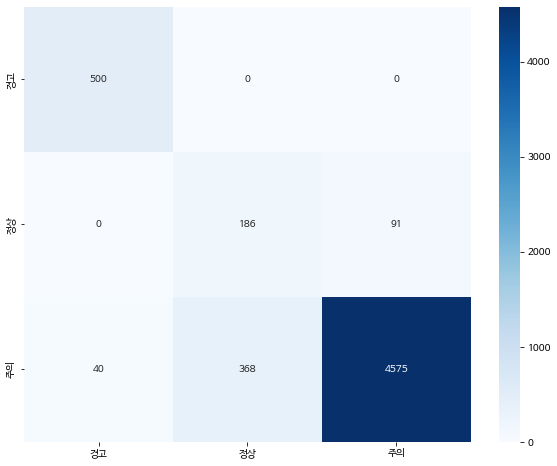

In [ ]:
cm = pd.DataFrame(confusion_matrix(predicted, yy), columns=['경고', '정상', '주의'], index=['경고', '정상', '주의'])
plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='d')
plt.show()

# Lesson & learned

## 이렇게 Domain knowledge가 많이 필요한 경우의 분석은 어떻게 하면 좋을까?

### 1. Domain knowledge가 많이 필요한 경우에도 데이터를 통해, 알아낼 수 있는 부분이 많이 있기 때문에 데이터를 먼저 분석해보는 것도 하나의 접근 방법
### 2. 하지만, 대부분의 경우에는 데이터 분석가가 놓칠 수 있는 관계가 존재하는 경우가 많기 때문에 Domain Expert와의 인터뷰가 매우 중요함
#### 3. 불가피하게 인터뷰를 할 수 없는 경우, 데이터가 보여주는 최선의 결과 (Feature Importance)를 이용하여 분석

### 이번 챕터에서는 공조설비의 상태를 예측하기 위해 공조설비에서 나오는 센서데이터를 분석해봤는데, 이러한 모터류의 센서데이터는 아주 강한 다중공선성이 존재함
### 공선성이 높은 데이터를 제외하고 모델링을 하는 것은 불가능하기 때문에 현재 데이터에서 최선의 결과를 얻을 수 있는 모델링 수행
### 이러한 결과로 공조설비의 건강상태(State Of Health) 신호등을 구성하여 설비 관리자에게 알람을 줄 수 있는 시나리오를 생각해볼 수 있음